In [1]:
!tree -d -L 2 ~/datasets/data/cityscapes

/home/skywatcher/datasets/data/cityscapes
├── gtCoarse
│   ├── train
│   ├── train_extra
│   └── val
├── gtFine
│   ├── test
│   ├── train
│   └── val
└── leftImg8bit
    ├── test
    ├── train
    ├── train_extra
    └── val

13 directories


In [1]:
#Import the packages
import os
import glob
from shutil import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import experimental as mixed_precision

#Set Memory Growth to alleviate memory issues
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
#Change policy to fp16 to use Tensor Cores
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

#Use the XLA compiler
'''
As per Tensorflow documentation
A simplest way to start using XLA in TensorFlow models is to enable auto-clustering,
which automatically finds clusters (connected subgraphs) within the TensorFlow graph
which can be compiled and executed using XLA.
'''
tf.config.optimizer.set_jit(True)

BATCH_SIZE=16
TARGET_SIZE=(1024,2048)

In [2]:
'''
Given a two lists of paths to images and masks, and two destination directories
for the images and masks.
'''
def cs_create_copies(images, masks, image_dest, mask_dest, mask_only=False):
    total = len(images)
    image_count = 0
    #For every image-mask pair
    for image, mask in zip(images, masks):
        #Get the filename we'll use
        filename = image.split('/')[-1]
        filename = filename[:filename.rindex('_')] + '.png'
        #Create the symbolic links
        if not mask_only:
            os.symlink(image, image_dest + '/' + filename)
        os.symlink(mask, mask_dest + '/' + filename)
        image_count+=1
        percentage = image_count/total*100
        print('Copying Images and Masks: %d%%\r'%(percentage),end="")

In [3]:
'''
A utility function to match two lists of files, mainly used in 
cs_preprocessing_files to ensure that the recieved file names from glob
match after each list has been sorted. This ensures that each image list is in the
same order as its corresponding mask list. In the case its not, then something has gone
wrong with the importing of files into the cityscapes directory.

@param images - A list of image files, when used in cs_preprocessing_files it will be absolute paths to the files
@param masks - A list of mask files, like images will be absolute when used in cs_preprocessing_files
'''
def cs_match_files(images, masks):
    #If the two lists are of equal size
    if len(images) == len(masks):
        #Go through file by file in each list
        for image, mask in zip(images, masks):
            #Get the sequence for cityscapes
            filename = image.split('/')[-1]
            match_to = filename[:filename.rindex('_')]
            #If the sequence isn't matching to the current mask then return False
            if match_to not in mask:
                print("The list hasn't been sorted properly")
                return False
    #Lists don't have the same size! return False.
    else:
        print("Lengths of the images and masks list do not match!")
        return False
    #Reaches here if all is good, so return True
    return True

In [4]:
'''
The task of this function will be to take the extracted cityscapes data
given by source, which I will assume is a directory containing the following
structure:
cityscapes
├── gtCoarse
│   ├── train
│   ├── train_extra
│   └── val
├── gtFine
│   ├── test
│   ├── train
│   └── val
└── leftImg8bit
    ├── test
    ├── train
    ├── train_extra
    └── val

This will be the structure if you downloaded the cityscapes dataset and extracted it.
The datasets you got should have been the leftImg8bit, leftImg8bit_trainextra, gtFine 
and gtCoarse.

@param source - the directory for cityscapes that has the structure mentioned above (This is best done as an absolute path)

'''
def cs_preprocessing_files(source):
    #Create all the variables
    fine_masks_dir = source + '/train/masks/all'
    coarse_masks_dir = source + '/train/coarse_masks/all'
    fine_train_dir = source + '/train/images/all'
    coarse_train_dir = source + '/train/coarse_images/all'
    val_fine_masks_dir = source + '/val/masks/all'
    val_coarse_masks_dir = source + '/val/coarse_masks/all'
    val_images_dir = source + '/val/images/all'
    
    #Create all the directories
    os.makedirs(fine_masks_dir, exist_ok=True)
    os.makedirs(coarse_masks_dir, exist_ok=True)
    os.makedirs(fine_train_dir, exist_ok=True)
    os.makedirs(coarse_train_dir, exist_ok=True)
    os.makedirs(val_fine_masks_dir, exist_ok=True)
    os.makedirs(val_coarse_masks_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    
    #Get all the paths of the images and sort them
    fine_images = glob.glob(source+'/leftImg8bit/train/*/*.png')
    fine_images.sort()
    coarse_images = fine_images + glob.glob(source + '/leftImg8bit/train_extra/*/*.png')
    coarse_images.sort()
    #Get all the masks and sort them
    fine_masks = glob.glob(source+'/gtFine/train/*/*color*.png')
    fine_masks.sort()
    coarse_masks = glob.glob(source+'/gtCoarse/train*/*/*color*.png')
    coarse_masks.sort()
    
    #Get all the validation paths and sort them
    val_images = glob.glob(source+'/leftImg8bit/val/*/*.png')
    val_images.sort()
    val_fine_masks = glob.glob(source+'/gtFine/val/*/*color*.png')
    val_fine_masks.sort()
    val_coarse_masks = glob.glob(source+'/gtCoarse/val/*/*color*.png')
    val_coarse_masks.sort()
    
    #Now verify all the paths have been retrieved and are in order
    if cs_match_files(fine_images, fine_masks):
        print('{} Fine Images and Masks Detected and in order'.format(len(fine_images)))
    if cs_match_files(fine_images, fine_masks):
        print('{} Coarse Images and Masks Detected and in order'.format(len(coarse_images)))
    if cs_match_files(val_images, val_fine_masks):
        print('{} Val Fine Images and Masks Detected and in order'.format(len(val_images)))
    if cs_match_files(val_images, val_coarse_masks):
        print('{} Val Coarse Images and Masks Detected and in order'.format(len(val_images)))
    
    #Now starting with the fine images, create the copies
    print("Copying the Fine Images and Masks")
    cs_create_copies(fine_images, fine_masks, fine_train_dir, fine_masks_dir)
    print("Copying the Fine Validation Images")
    cs_create_copies(val_images, val_fine_masks, val_images_dir, val_fine_masks_dir)
    print("Copying the Coarse Images and Masks")
    cs_create_copies(coarse_images, coarse_masks, coarse_train_dir, coarse_masks_dir)
    print("Copying the Coarse Validation Images and Masks")
    cs_create_copies(val_images, val_coarse_masks, val_images_dir, val_coarse_masks_dir, mask_only=True)

In [5]:
'''
An ImageDataGenerator will be created using keras ready for use in training TF2.0 models
like FastSCNN. 

@param images - The directory where all the training images are kept
@param masks - The directory where all the masks are kept
@param val_images - The directory where all validation images are kept
@param val_masks - The directory where all validation masks are kept
@param target_size - Should be a tuple of two numbers, the image size needed for the model should be put here. 
                     This will be largely dependent on the network you are training.
@return ImageDataGenerator - The ImageDataGenerator
'''
def cs_create_generators(images, masks, val_images, val_masks, target_size=TARGET_SIZE, batch_size=BATCH_SIZE):
    
    # we create two instances with the same arguments
    data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2,
                         rescale=1/255)
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    val_image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator(**data_gen_args)
    val_mask_datagen = ImageDataGenerator()
    
    # Provide the same seed to the flow methods
    seed = 42

    #Create the generators
    image_generator = image_datagen.flow_from_directory(
        images,
        class_mode=None,
        follow_links=True,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        seed=seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        masks,
        class_mode=None,
        follow_links=True,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        seed=seed)
    
    #Create the generators
    val_image_generator = val_image_datagen.flow_from_directory(
        val_images,
        class_mode=None,
        follow_links=True,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        seed=seed)
    
    val_mask_generator = val_mask_datagen.flow_from_directory(
        val_masks,
        class_mode=None,
        follow_links=True,
        target_size=target_size,
        batch_size=batch_size,
        color_mode='rgb',
        seed=seed)
    
    # combine generators into one which yields image and masks
    train_generator = (pair for pair in zip(image_generator, mask_generator))
    val_generator = (pair for pair in zip(val_image_generator, val_mask_generator))
    return train_generator, val_generator

In [6]:
cs_preprocessing_files('/home/skywatcher/datasets/data/cityscapes')

2975 Fine Images and Masks Detected and in order
22973 Coarse Images and Masks Detected and in order
500 Val Fine Images and Masks Detected and in order
500 Val Coarse Images and Masks Detected and in order
Copying the Fine Images and Masks
Copying the Fine Validation Images
Copying the Coarse Images and Masks
Copying the Coarse Validation Images and Masks


In [21]:
!tree -d -L 2 /home/skywatcher/datasets/data/cityscapes

/home/skywatcher/datasets/data/cityscapes
├── gtCoarse
│   ├── train
│   ├── train_extra
│   └── val
├── gtFine
│   ├── test
│   ├── train
│   └── val
├── leftImg8bit
│   ├── test
│   ├── train
│   ├── train_extra
│   └── val
├── train
│   ├── coarse_images
│   ├── coarse_masks
│   ├── images
│   └── masks
└── val
    ├── coarse_masks
    ├── images
    └── masks

22 directories


In [6]:
images = '/home/skywatcher/datasets/data/cityscapes/train/images'
masks = '/home/skywatcher/datasets/data/cityscapes/train/masks'
val_images = '/home/skywatcher/datasets/data/cityscapes/val/images'
val_masks = '/home/skywatcher/datasets/data/cityscapes/val/masks'
train_generator, val_generator = cs_create_generators(images, masks, val_images, val_masks, (512, 1024))

Found 2975 images belonging to 1 classes.
Found 2975 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [7]:
import fast_scnn
fastscnn = fast_scnn.model()
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.045)
fastscnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Before Cast: <dtype: 'float16'>
After Cast: <dtype: 'float32'>


In [ ]:
num_training = len(glob.glob(images+'/*/*'))
num_validation = len(glob.glob(val_images+'/*/*'))
fastscnn.fit_generator(
        train_generator,
        epochs=20,
        steps_per_epoch=np.ceil(num_training/BATCH_SIZE),
        validation_data=val_generator,
        validation_steps=np.ceil(num_validation/BATCH_SIZE),
        verbose=1)

Epoch 1/20
186/186 [==============================] - 1583s 9s/step - loss: 0.7724 - accuracy: 0.4634 - val_loss: 310.6168 - val_accuracy: 0.1096
Epoch 2/20
  6/186 [..............................] - ETA: 8:59 - loss: 0.8394 - accuracy: 0.4064

In [17]:
fastscnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 512, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 256, 512, 32) 128         conv2d_43[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Relu_44 (TensorFlow [(None, 256, 512, 32 0           batch_normalization_62[0][0]     
__________________________________________________________________________________________

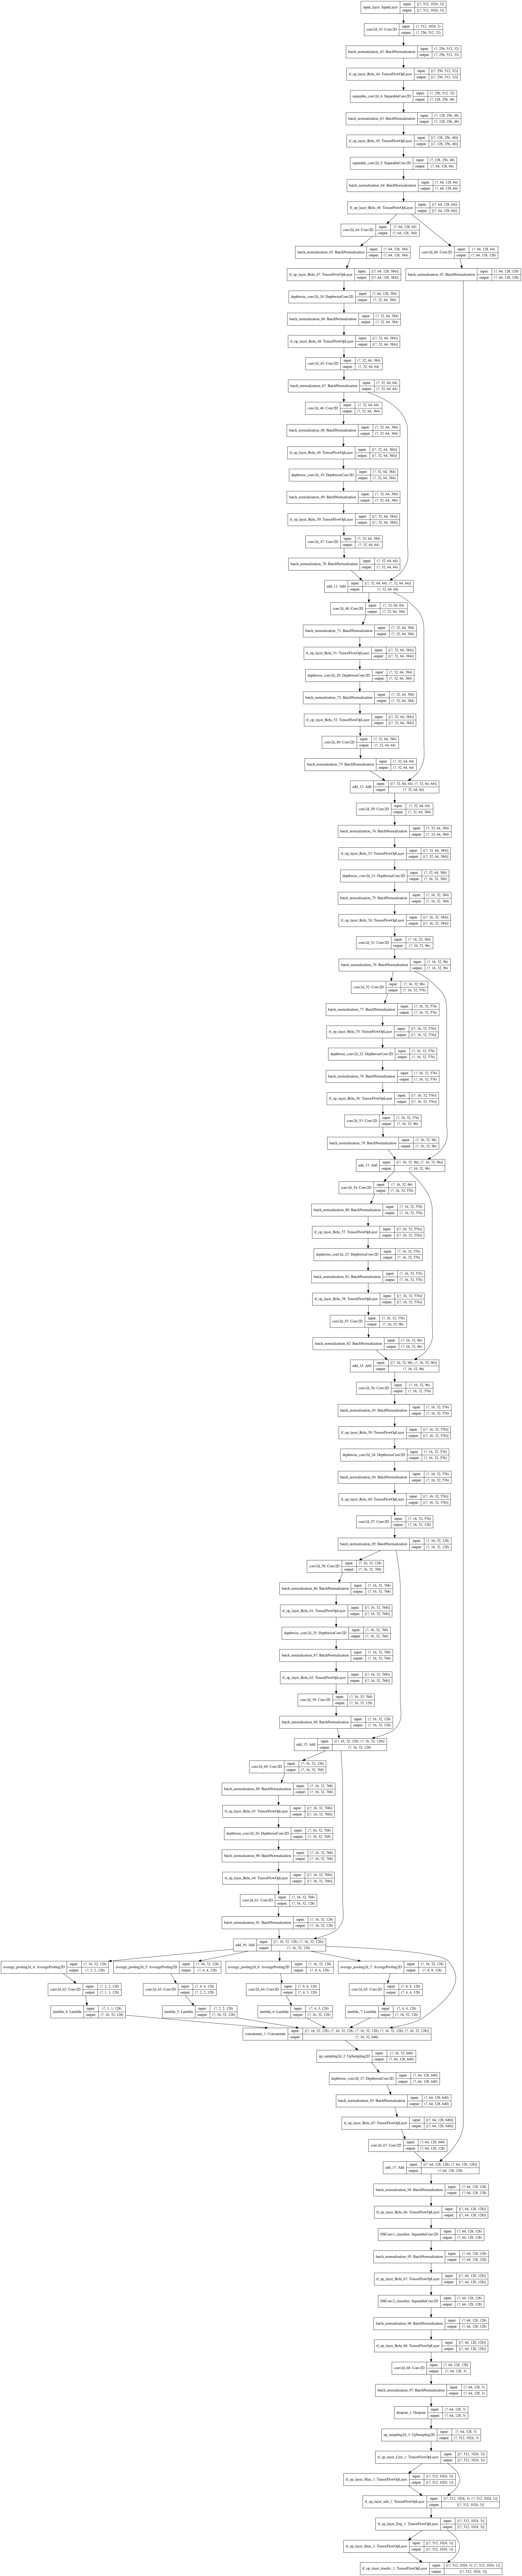

In [20]:
tf.keras.utils.plot_model(fastscnn, show_layer_names=True, show_shapes=True, to_file='./model_imgs/fast_scnn.png')

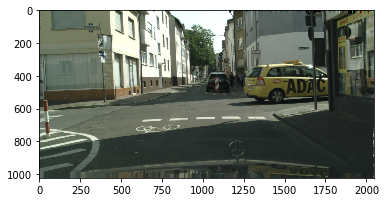

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

im = mpimg.imread("/home/skywatcher/datasets/data/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png")
plt.imshow(im)

image = Image.open("/home/skywatcher/datasets/data/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png")
image = image.resize((1024,512))
img_array = keras.preprocessing.image.img_to_array(image)

In [24]:
print(img_array.shape)
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)

(512, 1024, 3)
(1, 512, 1024, 3)


In [25]:
img_predict = fastscnn.predict(img_array)*255
print(img_predict.shape)
img_predict = np.squeeze(img_predict, axis=0)
print(img_predict.shape)

(1, 512, 1024, 3)
(512, 1024, 3)


In [28]:
predict_show = Image.fromarray(img_predict, 'RGB')
predict_show.save("./qualitative_results/test.png")